In [2]:
import ipywidgets as widgets
from IPython.display import display
import pandas as pd
import edhec_risk_kit as erk

%load_ext autoreload
%autoreload 2

## GBM Interactive Plots

<AxesSubplot:>

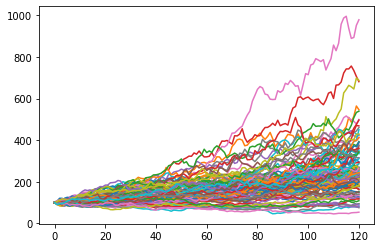

In [3]:
erk.gbm(10,100,mu=0.1).plot(legend=False)

In [4]:
def show_gbm(n_scenarios, mu, sigma):
    """
    Draw the results of a stock price evolution under a Geometric Brownian Motion Model
    """
    s_0 = 100
    prices = erk.gbm(n_scenarios=n_scenarios,mu=mu,sigma=sigma,s_0=s_0)
    ax = prices.plot(legend=False, color="indianred", alpha= 0.5, linewidth=2, figsize=(12,5))
    ax.axhline(y=s_0, ls=":", color="black")
    ax.set_ylim(top=400)
    ax.axis(xmin=0)
    # draw a dot at the origin
    ax.plot(0,s_0, marker='o',color='darkred',alpha=0.2)

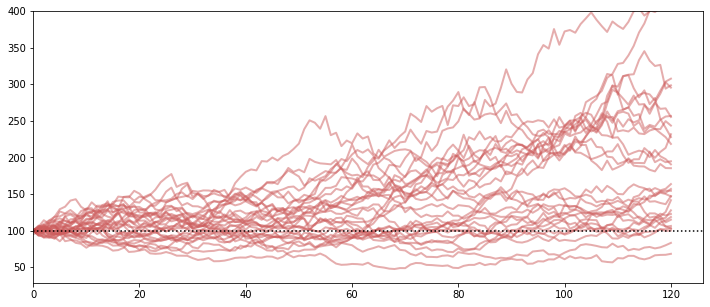

In [5]:
show_gbm(30,0.07,0.15)

In [6]:
gbm_controls = widgets.interactive(show_gbm,
                                  n_scenarios = (1,20,1), 
                                   mu = (-.2,.2,0.01), 
                                   sigma = (0,0.3,0.01)
                                  )

In [7]:
display(gbm_controls)

interactive(children=(IntSlider(value=10, description='n_scenarios', max=20, min=1), FloatSlider(value=0.0, de…

## Interactive CPPI Simulation - Monte Carlo

In [8]:
def show_cppi(n_scenarios=50, mu=0.07, sigma=0.15, m=3, floor=0, riskfree_rate=0.03, y_max=100):
    """
    Plot the results of a Monte Carlo Simulation of CPPI
    """
    start = 100
    sim_rets = erk.gbm(n_scenarios=n_scenarios, mu=mu, sigma=sigma, prices=False, steps_per_year=12)
    risky_r = pd.DataFrame(sim_rets)
    # run the "back"-test
    btr = erk.run_cppi(risky_r=pd.DataFrame(risky_r), riskfree_rate=riskfree_rate, m=m, start=start, floor=floor)
    wealth = btr["Wealth"]
    y_max=wealth.values.max()*y_max/100
    ax = wealth.plot(legend=False, alpha=0.3, color="indianred", figsize=(12,6))
    ax.axhline(y=start, ls=":", color="black")
    ax.axhline(y=start*floor, ls="--", color="red")
    ax.set_ylim(top=y_max)
    ax.axis(xmin=0)
cppi_controls = widgets.interactive(show_cppi,
                                    n_scenarios=widgets.IntSlider(min=1, max=1000, step=5, value=50),
                                    mu=(0.,+.2,.01),
                                    sigma=(0, .30, .05),
                                    floor=(0,2,.1),
                                    m=(1,5,.5),
                                    riskfree_rate=(0,.05,.01),
                                    y_max=widgets.IntSlider(min=0, max=100, step=1, value=100,description="Zoom Y Axis")
                                   )
display(cppi_controls)

interactive(children=(IntSlider(value=50, description='n_scenarios', max=1000, min=1, step=5), FloatSlider(val…

In [15]:
import matplotlib.pyplot as plt
def show_cppi(n_scenarios=50, mu=0.07, sigma=0.15, m=3, floor=0, riskfree_rate=0.03, y_max=100):
    """
    Plot the results of a Monte Carlo Simulation of CPPI
    """
    start = 100
    sim_rets = erk.gbm(n_scenarios=n_scenarios, mu=mu, sigma=sigma, prices=False, steps_per_year=12)
    risky_r = pd.DataFrame(sim_rets)
    # run the "back"-test
    btr = erk.run_cppi(risky_r=pd.DataFrame(risky_r), riskfree_rate=riskfree_rate, m=m, start=start, floor=floor)
    wealth = btr["Wealth"]
    # calculate terminal wealth stats
    y_max=wealth.values.max()*y_max/100
    terminal_wealth = wealth.iloc[-1]
    #Plot
    fig, (wealth_ax, hist_ax) = plt.subplots(nrows=1, ncols=2, sharey=True, gridspec_kw={'width_ratios': [3,2]},figsize=(24,9))
    plt.subplots_adjust(wspace=0.0) #both plots next to each other
    
    wealth.plot(ax=wealth_ax, legend=False, alpha=0.3, color="indianred")
    wealth_ax.axhline(y=start, ls=":", color="black")
    wealth_ax.axhline(y=start*floor, ls="--", color="red")
    wealth_ax.set_ylim(top=y_max)
    wealth_ax.axis(xmin=0)
    
    terminal_wealth.plot.hist(ax=hist_ax, bins=50, ec='w', fc='indianred', orientation='horizontal')
    hist_ax.axhline(y=start, ls=":", color="black")

cppi_controls = widgets.interactive(show_cppi,
                                    n_scenarios=widgets.IntSlider(min=1, max=1000, step=5, value=50),
                                    mu=(0.,+.2,.01),
                                    sigma=(0, .30, .05),
                                    floor=(0,2,.1),
                                    m=(1,5,.5),
                                    riskfree_rate=(0,.05,.01),
                                    y_max=widgets.IntSlider(min=0, max=100, step=1, value=100,description="Zoom Y Axis")
                                   )
display(cppi_controls)

interactive(children=(IntSlider(value=50, description='n_scenarios', max=1000, min=1, step=5), FloatSlider(val…

## show_cppi with violation

In [19]:
import numpy as np
def show_cppi(n_scenarios=50, mu=0.07, sigma=0.15, m=3, floor=0, riskfree_rate=0.03, y_max=100, steps_per_year=12):
    """
    Plot the results of a Monte Carlo Simulation of CPPI
    """
    start = 100
    sim_rets = erk.gbm(n_scenarios=n_scenarios, mu=mu, sigma=sigma, prices=False, steps_per_year=steps_per_year)
    risky_r = pd.DataFrame(sim_rets)
    # run the "back"-test
    btr = erk.run_cppi(risky_r=pd.DataFrame(risky_r), riskfree_rate=riskfree_rate, m=m, start=start, floor=floor)
    wealth = btr["Wealth"]
    
    # calculate terminal wealth stats
    y_max=wealth.values.max()*y_max/100
    terminal_wealth = wealth.iloc[-1]
    
    tw_mean = terminal_wealth.mean()
    tw_median = terminal_wealth.median()
    failure_mask = np.less(terminal_wealth, start*floor) #when terminal_wealth is less than start*floor, returns true
    n_failures = failure_mask.sum() # summing the true cases; True = 1 and False = 0
    p_fail = n_failures/n_scenarios
    
    #np.dot... product of the values and then summing it. 
    e_shortfall = np.dot(terminal_wealth-start*floor, failure_mask)/n_failures if n_failures > 0 else 0.0
    
    #Plot
    fig, (wealth_ax, hist_ax) = plt.subplots(nrows=1, ncols=2, sharey=True, gridspec_kw={'width_ratios': [3,2]},figsize=(24,9))
    plt.subplots_adjust(wspace=0.0) #both plots next to each other
    
    wealth.plot(ax=wealth_ax, legend=False, alpha=0.3, color="indianred")
    wealth_ax.axhline(y=start, ls=":", color="black")
    wealth_ax.axhline(y=start*floor, ls="--", color="red")
    wealth_ax.set_ylim(top=y_max)
    wealth_ax.axis(xmin=0)
    
    terminal_wealth.plot.hist(ax=hist_ax, bins=50, ec='w', fc='indianred', orientation='horizontal')
    hist_ax.axhline(y=start, ls=":", color="black")
    hist_ax.axhline(y=tw_mean, ls=":", color="blue")
    hist_ax.axhline(y=tw_median, ls=":", color="purple")
    hist_ax.annotate(f"Mean: ${int(tw_mean)}", xy=(.7,.9), xycoords='axes fraction', fontsize=24)
    hist_ax.annotate(f"Median: ${int(tw_median)}", xy=(.7,.85), xycoords='axes fraction', fontsize=24)
    if (floor > 0.01):
        hist_ax.axhline(y=start*floor, ls="--", color="red", linewidth=3)
        hist_ax.annotate(f"Violations: {n_failures} ({p_fail*100:2.2f}%)\nE(Shortfall)=${e_shortfall:2.2f}",xy=(.7,.7), xycoords='axes fraction', fontsize=24)

cppi_controls = widgets.interactive(show_cppi,
                                    n_scenarios=widgets.IntSlider(min=1, max=1000, step=5, value=50),
                                    mu=(0.,+.2,.01),
                                    sigma=(0, .50, .05),
                                    floor=(0,2,.1),
                                    m=(1,5,.5),
                                    riskfree_rate=(0,.05,.01),
                                    steps_per_year=widgets.IntSlider(min=1, max=12, step=1, value=12, description="Rebals/Year"),
                                    y_max=widgets.IntSlider(min=0, max=100, step=1, value=100,description="Zoom Y Axis")
                                   )
display(cppi_controls)

interactive(children=(IntSlider(value=50, description='n_scenarios', max=1000, min=1, step=5), FloatSlider(val…